# Twin Delayed DDPG (TD3)
### Solving `Pendulum-v1` Problem
> Deep RL course - Fall 2024 - Sharif University of Technology - Workshop session <br>
> Author: M Narimani - December 22nd, 2024 <br>

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model, layers
import gym
from datetime import datetime
from collections import deque
import matplotlib.pyplot as plt


AttributeError: 'RcParams' object has no attribute '_get'

In [ ]:
print("TensorFlow %s" % tf.__version__)
print("gym %s" % gym.__version__)
print("numpy %s" % np.__version__)

TensorFlow 2.15.0
gym 0.26.2
numpy 1.26.4


## TD3 Algorithm

<center>
<img src="td3_dong.png" alt="TD3 Dong et al." width=500/>
</center>

In [7]:
class Actor(Model):
    def __init__(self, action_dim, action_max, hidden_sizes=(300,)):
        super(Actor, self).__init__()
        self.action_max = action_max
        self.hidden_layers = []
        
        # Create hidden layers
        for h in hidden_sizes:
            self.hidden_layers.append(layers.Dense(h, activation='relu'))
            
        # Output layer
        self.output_layer = layers.Dense(action_dim, activation='tanh')
        
    def call(self, state):
        x = state
        for layer in self.hidden_layers:
            x = layer(x)
        return self.action_max * self.output_layer(x)

In [8]:
print(np.random.randn(2))

[-1.14031179  1.92880517]


In [9]:
class Critic(Model):
    def __init__(self, hidden_sizes=(300,)):
        super(Critic, self).__init__()
        self.hidden_layers = []
        
        # Create hidden layers
        for h in hidden_sizes:
            self.hidden_layers.append(layers.Dense(h, activation='relu'))
            
        # Output layer (Q-value)
        self.output_layer = layers.Dense(1)
        
    def call(self, inputs):
        state, action = inputs
        x = tf.concat([state, action], axis=-1)
        for layer in self.hidden_layers:
            x = layer(x)
        return tf.squeeze(self.output_layer(x), axis=1)

In [10]:
class ReplayBuffer:
    def __init__(self, max_size):
        self.buffer = deque(maxlen=max_size)
        self.max_size = max_size

    def store(self, state, action, reward, next_state, done):
        # Convert everything to float32 when storing
        state = np.array(state, dtype=np.float32)
        action = np.array(action, dtype=np.float32)
        reward = np.float32(reward)  # Convert scalar to float32
        next_state = np.array(next_state, dtype=np.float32)
        done = np.float32(done)  # Convert boolean to float32
        
        experience = (state, action, reward, next_state, done)
        self.buffer.append(experience)

    def sample_batch(self, batch_size):
        if batch_size > len(self.buffer):
            batch_size = len(self.buffer)

        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        states = []
        actions = []
        rewards = []
        next_states = []
        dones = []

        for idx in indices:
            s, a, r, s2, d = self.buffer[idx]
            states.append(s)
            actions.append(a)
            rewards.append(r)
            next_states.append(s2)
            dones.append(d)

        return {
            's': np.array(states, dtype=np.float32),
            'a': np.array(actions, dtype=np.float32),
            'r': np.array(rewards, dtype=np.float32),
            's2': np.array(next_states, dtype=np.float32),
            'd': np.array(dones, dtype=np.float32)
        }
    
    def __len__(self):
        return len(self.buffer)

In [21]:
class TD3:
    def __init__(
        self,
        env,
        hidden_sizes=(300,),
        replay_size=int(1e4),
        gamma=0.99,
        decay=0.995,
        mu_lr=1e-3,
        q_lr=1e-3,
        batch_size=100,
        action_noise=0.1,
        target_noise=0.2,
        noise_clip=0.5,
        policy_delay=2,
        max_episode_length=200
    ):
        self.env = env
        self.gamma = gamma
        self.decay = decay
        self.batch_size = batch_size
        self.action_noise = action_noise
        self.target_noise = target_noise                # TD3-specific: noise added to target actions
        self.noise_clip = noise_clip                    # TD3-specific: clipping of target noise
        self.policy_delay = policy_delay                # TD3-specific: delayed policy updates
        self.max_episode_length = max_episode_length
        
        # Extract environment dimensions
        self.num_states = self.env.observation_space.shape[0]
        #print(f"shape is : {self.env.observation_space.shape}")
        #print(f"shape is : {self.num_states}")

        self.num_actions = self.env.action_space.shape[0]
        self.action_max = self.env.action_space.high[0]
        
        # Create networks
        self.actor = Actor(self.num_actions, self.action_max, hidden_sizes)
        self.critic1 = Critic(hidden_sizes)
        self.critic2 = Critic(hidden_sizes)
        self.target_actor = Actor(self.num_actions, self.action_max, hidden_sizes)
        self.target_critic1 = Critic(hidden_sizes)
        self.target_critic2 = Critic(hidden_sizes)
        
        # Build networks (initialize weights)
        dummy_state = tf.zeros([1, self.num_states])
        dummy_action = tf.zeros([1, self.num_actions])
        self.actor(dummy_state)
        self.critic1([dummy_state, dummy_action])
        self.critic2([dummy_state, dummy_action])
        self.target_actor(dummy_state)
        self.target_critic1([dummy_state, dummy_action])
        self.target_critic2([dummy_state, dummy_action])
        
        # Copy weights to target networks
        self.target_actor.set_weights(self.actor.get_weights())
        self.target_critic1.set_weights(self.critic1.get_weights())
        self.target_critic2.set_weights(self.critic2.get_weights())
        
        # Create optimizers
        self.actor_optimizer = tf.keras.optimizers.Adam(mu_lr)
        self.critic1_optimizer = tf.keras.optimizers.Adam(q_lr)
        self.critic2_optimizer = tf.keras.optimizers.Adam(q_lr)
        
        # Create replay buffer
        self.replay_buffer = ReplayBuffer(replay_size)
        
        # Initialize step counter for delayed policy updates
        self.total_it = 0
        
    def get_action(self, s, noise_scale):
        a = self.actor(tf.convert_to_tensor(s.reshape(1,-1), dtype=tf.float32))
        a = a.numpy()[0]
        a += noise_scale * np.random.randn(self.num_actions)
        #print(a.shape)
        return np.clip(a, -self.action_max, self.action_max)
    
    @tf.function
    def update(self, batch):
        states = tf.convert_to_tensor(batch['s'], dtype=tf.float32)
        states_next = tf.convert_to_tensor(batch['s2'], dtype=tf.float32)
        actions = tf.convert_to_tensor(batch['a'], dtype=tf.float32)
        rewards = tf.convert_to_tensor(batch['r'], dtype=tf.float32)
        dones = tf.convert_to_tensor(batch['d'], dtype=tf.float32)
        
        # Add noise to target actions
        noise = tf.random.normal(tf.shape(actions), stddev=self.target_noise)
        noise = tf.clip_by_value(noise, -self.noise_clip, self.noise_clip)
        
        target_actions = self.target_actor(states_next)
        #print(target_actions.shape)
        target_actions = tf.clip_by_value(
            target_actions + noise,
            -self.action_max,
            self.action_max
        )
        
        # Get minimum Q-value between two critics
        target_q1 = self.target_critic1([states_next, target_actions])
        target_q2 = self.target_critic2([states_next, target_actions])
        target_q = tf.minimum(target_q1, target_q2)
        
        # Q targets
        q_target = rewards + self.gamma * (1 - dones) * target_q
        
        # Update first critic
        with tf.GradientTape() as tape:
            q1 = self.critic1([states, actions])
            critic1_loss = tf.reduce_mean((q1 - q_target)**2)
        
        critic1_gradients = tape.gradient(critic1_loss, self.critic1.trainable_variables)
        self.critic1_optimizer.apply_gradients(
            zip(critic1_gradients, self.critic1.trainable_variables)
        )
        
        # Update second critic
        with tf.GradientTape() as tape:
            q2 = self.critic2([states, actions])
            critic2_loss = tf.reduce_mean((q2 - q_target)**2)
        
        critic2_gradients = tape.gradient(critic2_loss, self.critic2.trainable_variables)
        self.critic2_optimizer.apply_gradients(
            zip(critic2_gradients, self.critic2.trainable_variables)
        )
        
        # Delayed policy updates
        if self.total_it % self.policy_delay == 0:
            # Update actor
            with tf.GradientTape() as tape:
                actor_actions = self.actor(states)
                actor_loss = -tf.reduce_mean(self.critic1([states, actor_actions]))
            
            actor_gradients = tape.gradient(actor_loss, self.actor.trainable_variables)
            self.actor_optimizer.apply_gradients(
                zip(actor_gradients, self.actor.trainable_variables)
            )
            
            # Update target networks
            self.update_target_networks()
        else:
            actor_loss = tf.constant(0.0)
        
        return critic1_loss, critic2_loss, actor_loss
    
    def update_target_networks(self):
        # Update target networks using soft update
        for target, main in zip(self.target_actor.variables, self.actor.variables):
            target.assign(self.decay * target + (1 - self.decay) * main)
        
        for target, main in zip(self.target_critic1.variables, self.critic1.variables):
            target.assign(self.decay * target + (1 - self.decay) * main)
            
        for target, main in zip(self.target_critic2.variables, self.critic2.variables):
            target.assign(self.decay * target + (1 - self.decay) * main)
    
    def train(self, num_episodes):
        returns = []
        # test_returns = []
        critic1_losses = []
        critic2_losses = []
        actor_losses = []

        print(f"Using random actions for the initial {self.replay_buffer.max_size} steps...")

        for episode in range(num_episodes):
            state, episode_return, episode_length = self.env.reset()[0], 0, 0
            #print(f"at the start: state: {state} shape: {state.shape}")
            done = False

            while not (done or episode_length == self.max_episode_length):
                # Use agent's actions only after buffer has enough samples
                if len(self.replay_buffer) >= self.replay_buffer.max_size: #self.batch_size:
                    action = self.get_action(state, self.action_noise)
                    print(f"actions: {action} and its shape: {action.shape}")

                else:
                    action = self.env.action_space.sample()
                
                # Take action in environment
                next_state, reward, done, _, _ = self.env.step(action)
                episode_return += reward
                episode_length += 1
                
                # Store transition
                done_store = False if episode_length == self.max_episode_length else done
                self.replay_buffer.store(state, action, reward, next_state, done_store)
                
                if len(self.replay_buffer) == self.replay_buffer.max_size-1: #self.batch_size:
                    print(f"Memory full. Performing agent actions from now on.")
                
                # Update state
                state = next_state
                
                # Update networks if buffer has enough samples
                if len(self.replay_buffer) >= self.batch_size:
                    batch = self.replay_buffer.sample_batch(self.batch_size)
                    critic1_loss, critic2_loss, actor_loss = self.update(batch)
                    critic1_losses.append(critic1_loss.numpy())
                    critic2_losses.append(critic2_loss.numpy())
                    actor_losses.append(actor_loss.numpy())
                    self.total_it += 1
            
            if (episode + 1) % 10 == 0:
                print(f"Episode: {episode + 1:4d} | "
                       # f"ACTION: {action.shape} | "

                      f"Score: {int(episode_return):5d} | "
                      f"Memory: {len(self.replay_buffer):5d} | "
                      f"Actor Loss: {actor_loss.numpy():.2f} | "
                      f"Critic 1 Loss: {critic1_loss.numpy():.2f} | "
                      f"Critic 2 Loss: {critic2_loss.numpy():.2f}")
                
            returns.append(episode_return)
        
        return returns, critic1_losses, critic2_losses, actor_losses

In [22]:
%%time

env = gym.make('Pendulum-v1')
agent = TD3(env,gamma=0.99,policy_delay=2,target_noise=0.2,noise_clip=0.5)
returns, critic1_losses, critic2_losses, actor_losses = agent.train(num_episodes=200)

Using random actions for the initial 10000 steps...
Episode:   10 | Score:  -966 | Memory:  2000 | Actor Loss: 45.89 | Critic 1 Loss: 1.11 | Critic 2 Loss: 1.22
Episode:   20 | Score:  -857 | Memory:  4000 | Actor Loss: 63.07 | Critic 1 Loss: 5.46 | Critic 2 Loss: 4.91
Episode:   30 | Score: -1069 | Memory:  6000 | Actor Loss: 85.07 | Critic 1 Loss: 5.59 | Critic 2 Loss: 5.44
Episode:   40 | Score:  -965 | Memory:  8000 | Actor Loss: 105.94 | Critic 1 Loss: 6.31 | Critic 2 Loss: 5.83
Memory full. Performing agent actions from now on.
Episode:   50 | Score: -1244 | Memory: 10000 | Actor Loss: 115.67 | Critic 1 Loss: 6.24 | Critic 2 Loss: 5.42
actions: [1.8486335] and its shape: (1,)
actions: [2.] and its shape: (1,)
actions: [1.9979365] and its shape: (1,)
actions: [1.969833] and its shape: (1,)
actions: [2.] and its shape: (1,)
actions: [1.9789759] and its shape: (1,)
actions: [2.] and its shape: (1,)
actions: [1.9301269] and its shape: (1,)
actions: [2.] and its shape: (1,)
actions: [

# Results
## Learning curves

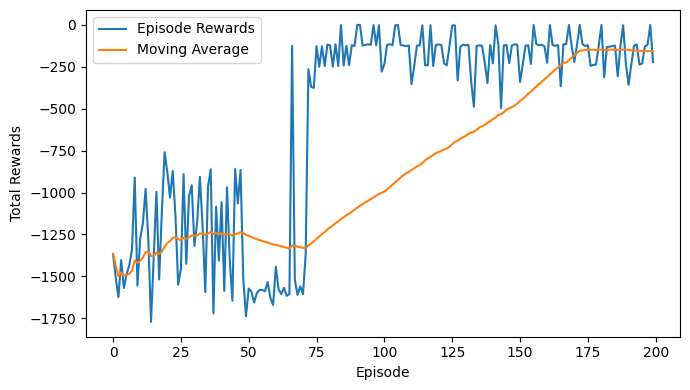

In [8]:
def running_avg(totalrewards):
    N = len(totalrewards)
    totalrewards = np.array(totalrewards)
    running_avg = np.empty(N)
    for t in range(N):
        running_avg[t] = totalrewards[max(0, t-100):(t+1)].mean()
    return running_avg

plt.figure(figsize=(7, 4))
plt.plot(returns, label='Episode Rewards')
plt.plot(running_avg(returns), label='Moving Average')
plt.xlabel('Episode')
plt.ylabel('Total Rewards')
plt.legend()
plt.tight_layout()
plt.show()

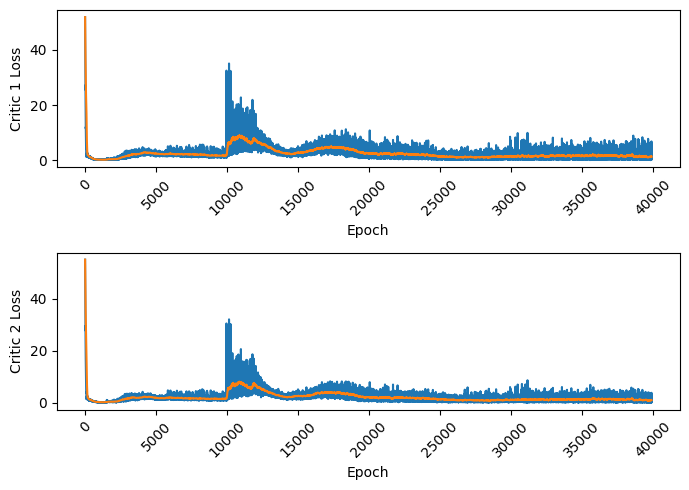

In [9]:
plt.figure(figsize=(7, 5))
plt.subplot(2, 1, 1)
plt.plot(critic1_losses, label='Critic 1 Losses')
plt.plot(running_avg(np.array(critic1_losses)), label='Running Avg Critic 1')
plt.xlabel('Epoch')
plt.ylabel('Critic 1 Loss')
plt.xticks(rotation=45)
# plt.legend()
plt.subplot(2, 1, 2)
plt.plot(critic2_losses, label='Critic 2 Losses')
plt.plot(running_avg(np.array(critic2_losses)), label='Running Avg Critic 2')
plt.xlabel('Epoch')
plt.ylabel('Critic 2 Loss')
plt.xticks(rotation=45)
# plt.legend()
plt.tight_layout()
plt.show()

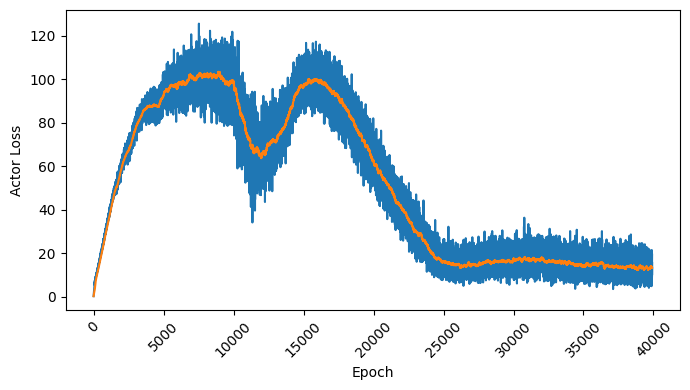

In [10]:
plt.figure(figsize=(7, 4))
plt.plot(actor_losses)
plt.plot(running_avg(np.array(actor_losses)))
plt.xlabel('Epoch')
plt.ylabel('Actor Loss')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Cost-to-go

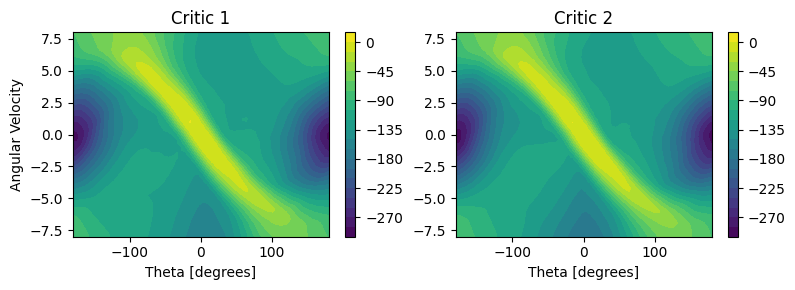

In [11]:
# TODO

## Policy map

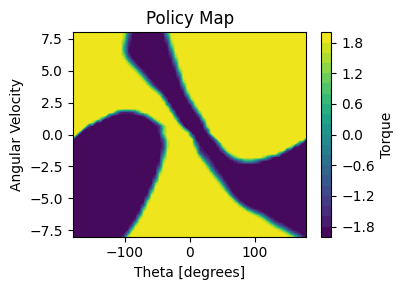

In [12]:
# TODO

## State histogram

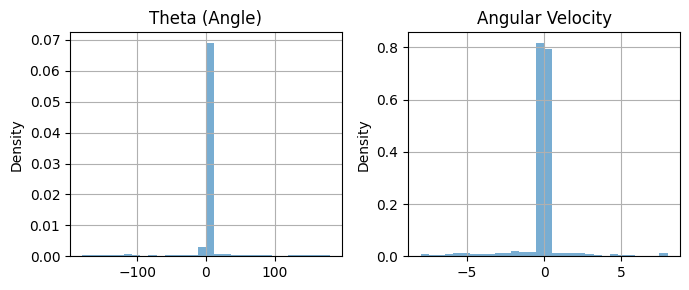

In [13]:
# TODO

## Render the learned policy

In [15]:
from IPython.display import Video, display
import cv2

def render_pendulum(agent):
    num_timesteps = 200
    env = gym.make('Pendulum-v1', render_mode='rgb_array')
    state, _ = env.reset()
    video_path = "TD3_render.mp4"
    frame_width, frame_height = env.render().shape[1], env.render().shape[0]
    fourcc = cv2.VideoWriter_fourcc(*'avc1')
    out = cv2.VideoWriter(video_path, fourcc, 30, (frame_width, frame_height))
    for _ in range(num_timesteps):
        action = agent.get_action(state, 0)
        state, reward, done, _, _ = env.step(action)
        frame = env.render()
        frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)  # Convert RGB to BGR for OpenCV
        out.write(frame_bgr)
    out.release()
    env.close()
    display(Video(video_path))

render_pendulum(agent)